# Test log-ratios derived from differential abundance/expression tools on the test dataset

In [28]:
import math
import random
import sklearn
import pandas as pd
import biom
import matplotlib
from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression
from qiime2 import Artifact

In [29]:
# Get the LaTeX math mode stuff working as expected: https://stackoverflow.com/a/23856968
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

## Load relevant data for all differential abundance outputs

In [30]:
metadata = pd.read_csv("../data/final_metadata.tsv", sep="\t", index_col=0)

In [31]:
cancer_metadata = metadata.loc[metadata["Status"] != "N"]

In [32]:
testcm = cancer_metadata.loc[cancer_metadata["TrainTest"] == "Test"]
traincm = cancer_metadata.loc[cancer_metadata["TrainTest"] == "Train"]
print(f"{testcm.shape[0]} test cancer samples.")
print(f"{traincm.shape[0]} train cancer samples.")
testcm

29 test cancer samples.
67 train cancer samples.


,Age,Gender,Status,TotalNumReads,NumUniquelyMappedReads,UniquelyMappedReadsPercentage,CancerSubtype,ChemotherapyStatus,GnRHTherapyStatus,TAMTherapyStatus,AITherapyStatus,BSOTherapyStatus,TrainTest
SampleID,,,,,,,,,,,,,
C2,43.35,Female,C-R,"7,870,895","6,526,361",82.92%,TripleNegative,A,NaN,NaN,NaN,NaN,Test
C4,41.42,Female,C-R,"8,248,171","7,041,599",85.37%,TripleNegative,A,NaN,NaN,NaN,NaN,Test
C5,42.12,Female,C-R,"9,233,397","7,922,603",85.80%,LuminalA/Normal-like,D,B,B,NaN,NaN,Test
C6,36.52,Female,C-R,"7,156,841","6,140,656",85.80%,LuminalA/Normal-like,A,B,NaN,NaN,NaN,Test
C8,37.35,Female,C-R,"8,374,268","7,298,256",87.15%,LuminalA/Normal-like,A,NaN,B,NaN,NaN,Test
C11,44.98,Female,C-R,"6,848,186","5,824,106",85.05%,LuminalA/Normal-like,A,NaN,NaN,NaN,NaN,Test
C12,34.71,Female,C-R,"7,093,422","5,976,848",84.26%,TripleNegative,D,NaN,NaN,NaN,NaN,Test
C15,36.61,Female,C-R,"7,620,354","6,510,882",85.44%,TripleNegative,A,NaN,NaN,NaN,NaN,Test
C26,38.41,Female,C-R,"7,799,765","6,661,309",85.40%,HER2Enriched,A,A,NaN,NaN,NaN,Test


In [33]:
with open("output/cancer_table_with_header.tsv", "r") as cancer_tsv_file:
    tbl = biom.Table.from_tsv(cancer_tsv_file, None, None, lambda x: x)
tbl

60675 x 96 <class 'biom.table.Table'> with 2631345 nonzero entries (45% dense)

## Utility function: Show a fancy box- /jitter- plot of recurrent vs. nonrecurrent samples for some samples and a log-ratio

Takes as input a DataFrame of sample metadata, the selected numerator and denominator features in a log-ratio, and some other parameters.

In [60]:
def lr_boxjitterplot(sampledf, num_features, den_features, title, ax, sampleid2color=None):

    # These are now "vectors" of sample IDs by sums
    def filter_and_sum_tbl(t, features, samples):
        featurefiltered_tbl = t.filter(features, axis="observation", inplace=False)
        samplefiltered_tbl = featurefiltered_tbl.filter(samples, axis="sample", inplace=False)
        return samplefiltered_tbl.sum(axis="sample")

    num_sum = filter_and_sum_tbl(tbl, num_features, sampledf.index)
    den_sum = filter_and_sum_tbl(tbl, den_features, sampledf.index)

    sampleid2logratio = {}
    cr_logratios = []
    cn_logratios = []
    excluded_samples = []
    # The numpy arrays representing the summed tables above don't really have sample labels any more,
    # but the samples seem to be in the same order as in sampledf.index.
    # Ideally we would do this more safely, since I am not 100% sure this order staying constant is guaranteed.
    for si, samp in enumerate(sampledf.index):
        if num_sum[si] > 0 and den_sum[si] > 0:
            logratio = math.log(num_sum[si] / den_sum[si], math.e)
            sampleid2logratio[samp] = logratio
        else:
            raise ValueError("Can't handle sample dropping yet. Use broader log-ratios?")
#             sampleid2logratio[samp] = None
#             excluded_samples.append(samp)
#             continue
        samp_status = sampledf["Status"][samp]
        if samp_status == "C-R":
            cr_logratios.append(logratio)
        elif samp_status == "C-N":
            cn_logratios.append(logratio)
        else:
            raise ValueError("excuse me")

    # Draw a horizontal grid, but behind the bars: to do this we use distinct zorders.
    # From https://stackoverflow.com/a/23358722.
    ax.grid(axis="y", zorder=0)

    # Draw a nice boxplot...
    ax.boxplot([cn_logratios, cr_logratios], labels=["C-N", "C-R"], zorder=100, sym="",
               medianprops={"color": "#000000", "linewidth": 3}, boxprops={"linewidth": 3},
               whiskerprops={"linewidth": 2}, capprops={"linewidth": 2})

    # ... and also draw the actual points behind the scatterplot at low transparency.
    # This approach is based on https://stackoverflow.com/a/29780292, which was in turn based on
    # https://nbviewer.jupyter.org/gist/fonnesbeck/5850463.
    jitter = 0.12
    get_jitter = lambda x: ((random.random() * jitter * random.choice([1, -1]))) + x
    for si, samp in enumerate(sampledf.index):
        if sampleid2logratio[samp] is not None:
            samp_status = sampledf["Status"][samp]

            # matplotlib uses x values of 1 for C-N (the first boxplot category)
            # and 2 for C-R. No idea why these are 1-indexed instead of 0-indexed (using x=0 didn't
            # seem to show any points...?), but I'm not gonna question it.
            if samp_status == "C-N":
                x = get_jitter(1)
            else:
                x = get_jitter(2)

            if sampleid2color is None:
                sc = "#007799" if samp_status == "C-N" else "#cc3300"
            else:
                sc = sampleid2color[samp]

            ax.scatter(x, sampleid2logratio[samp], alpha=0.5, color=sc, zorder=5)

    # To make the plot look prettier (?) hide the top and right lines. From https://stackoverflow.com/a/28720127.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_title(title, fontsize=16)
    ax.set_ylabel("Log-Ratio", fontsize=15)
    ax.set_xlabel("Recurrence Status", fontsize=15)

    ax.tick_params(labelsize=16)
    
    if len(excluded_samples) > 0:
        print("Samples excluded:", excluded_samples)
    
    return sampleid2logratio

## Utility function: apply logistic regression to the training data, then see how well the log-ratio generalizes to the test data

In [61]:
def logistic_regression_on_logratios(trsamp2lr, tesamp2lr):
    
    # 0 for C-N (nonrecurrent), 1 for C-R (recurrent)
    training_truth_classes = []
    input_training_data = []
    training_sample_order = list(trsamp2lr.keys())
    for samp in training_sample_order:
        if traincm["Status"][samp] == "C-N":
            training_truth_classes.append(0)
        else:
            training_truth_classes.append(1)
        # Needs to be a 2-D array
        input_training_data.append([trsamp2lr[samp]])
            
    lrm = LogisticRegression(random_state=333).fit(input_training_data, training_truth_classes)
        
    test_truth_classes = []
    input_test_data = []
    test_sample_order = list(tesamp2lr.keys())
    for samp in test_sample_order:
        if testcm["Status"][samp] == "C-N":
            test_truth_classes.append(0)
        else:
            test_truth_classes.append(1)
        input_test_data.append([tesamp2lr[samp]])
    
    predictions = lrm.predict(input_test_data)
    
    print("Test ground truths:", test_truth_classes)
    print("Test predictions:  ", list(predictions))
    
    # We are a bit lazy here, and rather than directly mapping samples to false positive, false negative,
    # true positive, true negative we just map them to the color of their classification. this should make
    # visually highlighting misclassifications obvious on a plot.
    testsamp2color = {}
    
    tp = fp = tn = fn = 0
    for si, samp in enumerate(test_sample_order):
        real_val = test_truth_classes[si]
        pred_val = predictions[si]
        if real_val == 0:
            if pred_val == 0:
                tn += 1
                testsamp2color[samp] = "#007799"
            else:
                fp += 1
                testsamp2color[samp] = "#cc3300"
        else:
            if pred_val == 0:
                fn += 1
                testsamp2color[samp] = "#007799"
            else:
                tp += 1
                testsamp2color[samp] = "#cc3300"
                
    print(f"True positives: {tp}")
    print(f"False positives: {fp}")
    print(f"True negatives: {tn}")
    print(f"False negatives: {fn}")
    
    acc = (tp + tn) / (tp + tn + fp + fn)
    
    print(f"Accuracy: {100*acc:.2f}%")
    
    return (tp, fp, tn, fn, testsamp2color)

## Utility function: run full visualization &rarr; regression &rarr; visualization pipeline

In [96]:
def run_pipeline(num_features, den_features, numdesc, dendesc, fileprefix=None):
    
    # Show log-ratio on training and testing samples
    fig, (ax1, ax2) = pyplot.subplots(1, 2, gridspec_kw={"wspace": 1}, sharey=True)

    trsamp2lr = lr_boxjitterplot(traincm, num_features, den_features, "Training samples", ax1)
    tesamp2lr = lr_boxjitterplot(testcm, num_features, den_features, "Testing samples", ax2)
    
    # Although we do want to use sharey to make sure both the training and test sample plots have
    # the same y-ranges, we still want to show y-labels on both plots. We do this by re-setting each
    # tick label to visible: https://stackoverflow.com/a/29268007
    ax2.yaxis.set_tick_params(labelleft=True)

    suptitle = "$\log \\bigg(\\dfrac{\\text{" + numdesc + "}}{\\text{" + dendesc + "}}$\\bigg)"
    fig.suptitle(suptitle, fontsize=17, y=1.1, fontweight="bold")
    fig.set_size_inches(6, 5)
    if fileprefix is not None:
        fig.savefig(f"../figs/results/{fileprefix}-logratios.png", bbox_inches="tight")
    
    # Run logistic regression
    tp, fp, tn, fn, sid2color = logistic_regression_on_logratios(trsamp2lr, tesamp2lr)
    
    # Show log-ratio, coloring testing samples by assigned classification
    fig2, (ax3, ax4) = pyplot.subplots(1, 2, gridspec_kw={"wspace": 1}, sharey=True)

    lr_boxjitterplot(traincm, num_features, den_features, "Training samples", ax3)
    lr_boxjitterplot(testcm, num_features, den_features, "Testing samples", ax4, sid2color)
    
    ax4.yaxis.set_tick_params(labelleft=True)

    fig2.suptitle(suptitle, fontsize=17, y=1.1, fontweight="bold")
    fig2.set_size_inches(6, 5)
    if fileprefix is not None:
        fig2.savefig(f"../figs/results/{fileprefix}-logratios-with-test-classifications.png", bbox_inches="tight")

## Utility function: run pipeline, based on some percentage of features

In [88]:
def run_pipeline_n_pct(sorted_differentials, pct, toolname):
    pct_unrounded = (pct/100) * len(sorted_differentials)
    pct_rounded = round(pct_unrounded)
    print(f"{pct}% of {len(status_diffs)} features = {pct_unrounded:.2f} features (rounded: {pct_rounded} features)")
    den_features = sorted_differentials[:pct_rounded].index
    num_features = sorted_differentials[-pct_rounded:].index
    assert len(den_features) == len(num_features) == pct_rounded

    run_pipeline(
        num_features, den_features,
        f"Top {pct}\% of genes ranked by {toolname}",
        f"Bottom {pct}\% of genes ranked by {toolname}",
        f"{toolname.lower()}-{pct}pct"
    )

## Evaluate Songbird results

In [89]:
diffs_qza = Artifact.load("output/songbird-results/status-diffs.qza")
diffs = diffs_qza.view(pd.DataFrame)
status_diffs = diffs[diffs.columns[1]].sort_values()
status_diffs

featureid
ENSG00000261857   -2.380946
ENSG00000280236   -1.532800
ENSG00000156076   -1.212925
ENSG00000248822   -1.209955
ENSG00000173486   -1.085119
                     ...   
ENSG00000173267    1.216038
ENSG00000185338    1.232798
ENSG00000175063    1.262340
ENSG00000204632    1.265787
ENSG00000172354    1.476348
Name: C(Status, Treatment('C-N'))[T.C-R], Length: 741, dtype: float64

### Songbird Log-Ratio: $\log\bigg(\dfrac{\text{Top 2% of features}}{\text{Bottom 2% of features}}\bigg)$

2% of 741 features = 14.82 features (rounded: 15 features)
Test ground truths: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test predictions:   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True positives: 0
False positives: 4
True negatives: 15
False negatives: 10
Accuracy: 51.72%


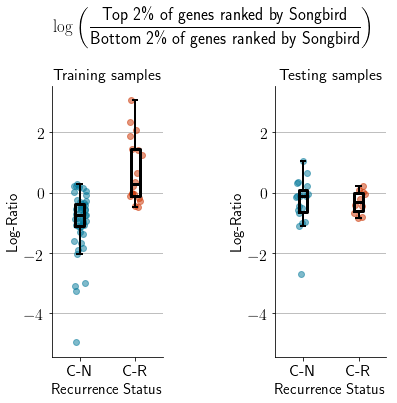

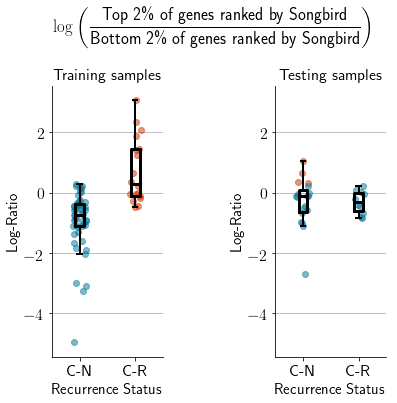

In [98]:
run_pipeline_n_pct(status_diffs, 2, "Songbird")

### Songbird Log-Ratio: $\log\bigg(\dfrac{\text{Top 5% of features}}{\text{Bottom 5% of features}}\bigg)$

5% of 741 features = 37.05 features (rounded: 37 features)
Test ground truths: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test predictions:   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True positives: 0
False positives: 2
True negatives: 17
False negatives: 10
Accuracy: 58.62%


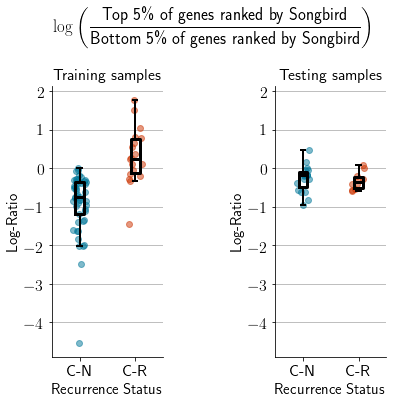

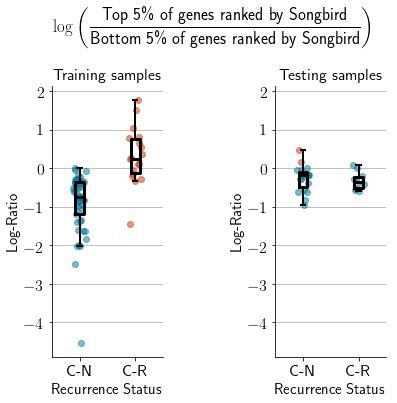

In [99]:
run_pipeline_n_pct(status_diffs, 5, "Songbird")

### Songbird Log-Ratio: $\log\bigg(\dfrac{\text{Top 10% of features}}{\text{Bottom 10% of features}}\bigg)$

10% of 741 features = 74.10 features (rounded: 74 features)
Test ground truths: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test predictions:   [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True positives: 1
False positives: 0
True negatives: 19
False negatives: 9
Accuracy: 68.97%


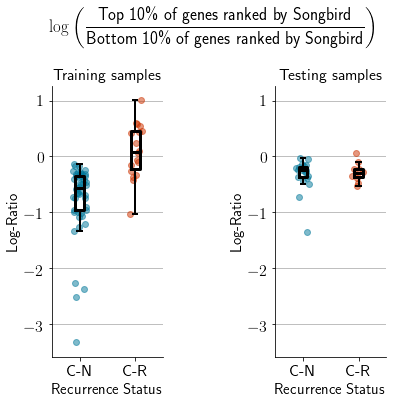

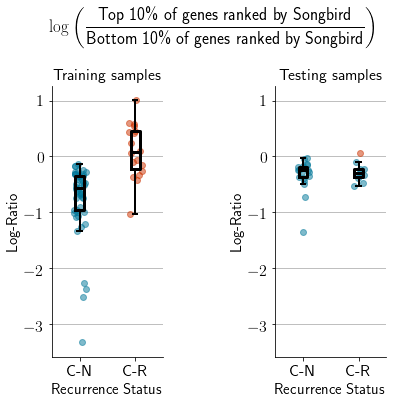

In [100]:
run_pipeline_n_pct(status_diffs, 10, "Songbird")

### Songbird Log-Ratio: $\log\bigg(\dfrac{\text{Top 50% of features}}{\text{Bottom 50% of features}}\bigg)$

50% of 741 features = 370.50 features (rounded: 370 features)
Test ground truths: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test predictions:   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True positives: 0
False positives: 0
True negatives: 19
False negatives: 10
Accuracy: 65.52%


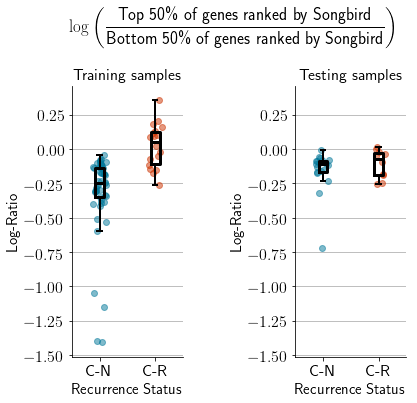

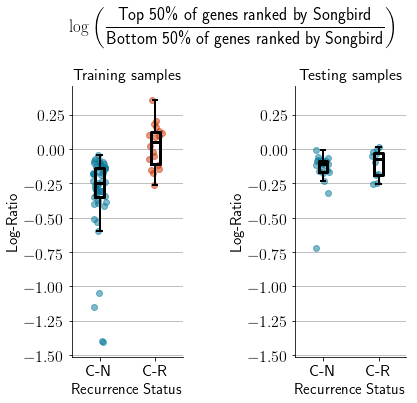

In [101]:
run_pipeline_n_pct(status_diffs, 50, "Songbird")

## Evaluate limma results

In [102]:
limma_fc = pd.read_csv("../data/limma_output.tsv", sep="\t", index_col=0)["logFC"].sort_values()
limma_fc

FeatureID
ENSG00000243260   -2.477748
ENSG00000222743   -2.419133
ENSG00000253042   -2.329253
ENSG00000272795   -2.253379
ENSG00000282834   -2.228284
                     ...   
ENSG00000233343    1.772927
ENSG00000202402    1.803049
ENSG00000242190    1.824174
ENSG00000251940    1.960748
ENSG00000227303    2.014730
Name: logFC, Length: 56392, dtype: float64

### limma Log-Ratios: 2%, 5%, 10%, 50%

2% of 741 features = 1127.84 features (rounded: 1128 features)
Test ground truths: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test predictions:   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True positives: 10
False positives: 0
True negatives: 19
False negatives: 0
Accuracy: 100.00%
5% of 741 features = 2819.60 features (rounded: 2820 features)
Test ground truths: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test predictions:   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True positives: 10
False positives: 0
True negatives: 19
False negatives: 0
Accuracy: 100.00%
10% of 741 features = 5639.20 features (rounded: 5639 features)
Test ground truths: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test predictions:   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

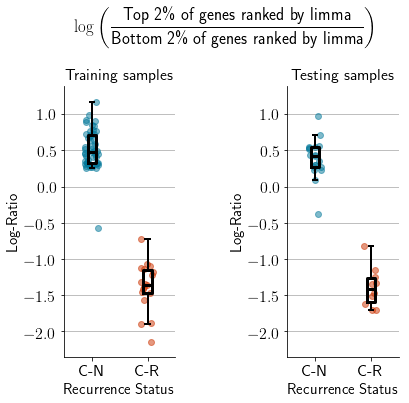

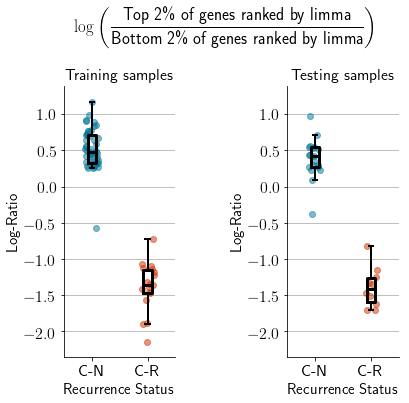

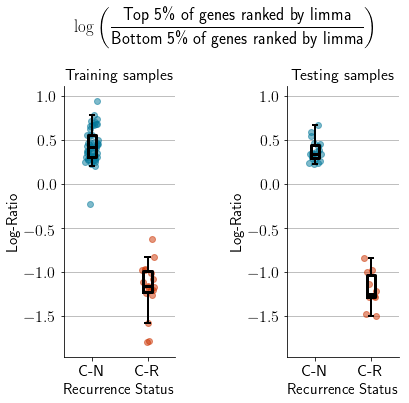

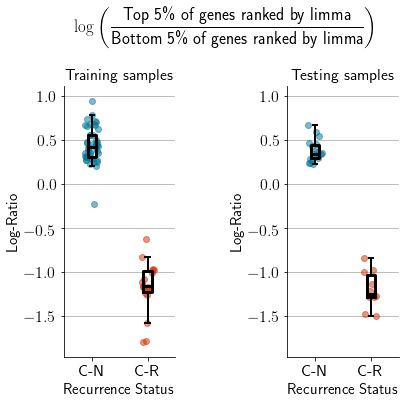

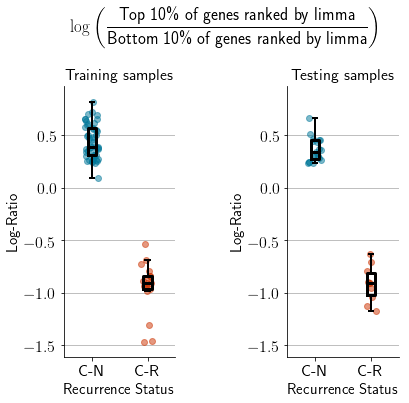

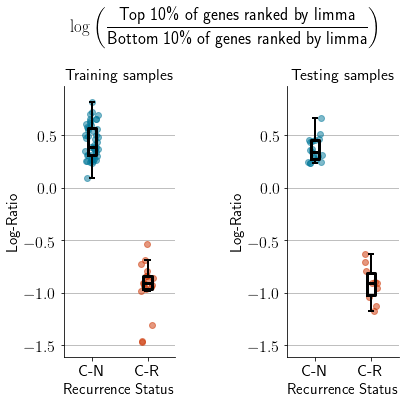

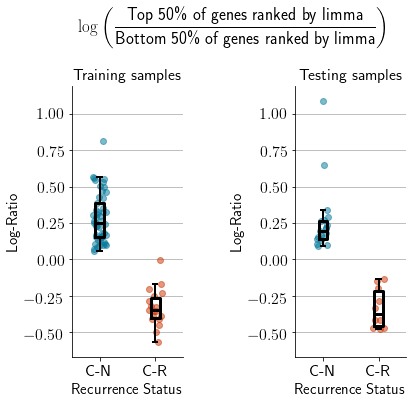

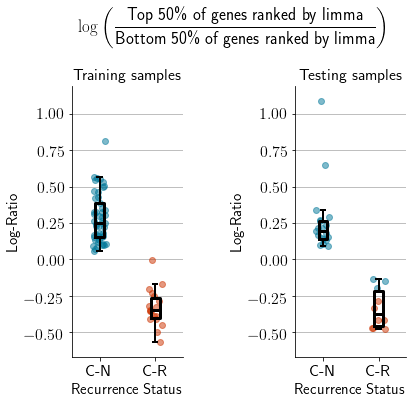

In [103]:
for pct in (2, 5, 10, 50):
    run_pipeline_n_pct(limma_fc, pct, "limma")